<a href="https://colab.research.google.com/github/the-aryan-1712/phDOS-Prediction-using-ENN/blob/main/phDOS_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ninarina12/phononDoS_tutorial.git
%cd phononDoS_tutorial

Cloning into 'phononDoS_tutorial'...
remote: Enumerating objects: 312, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 312 (delta 7), reused 12 (delta 4), pack-reused 294 (from 1)
Receiving objects: 100% (312/312), 83.18 MiB | 8.63 MiB/s, done.
Resolving deltas: 100% (160/160), done.
Updating files: 100% (15/15), done.
/content/phononDoS_tutorial


In [ ]:
!pip install ase e3nn
!pip install torch-scatter torch-cluster torch-sparse torch-spline-conv -f https://pytorch-geometric.com/whl/torch-$(python -c "import torch; print(torch.__version__)").html
!pip install torch-geometric
!pip install mp_api
# model
import torch
import re
import warnings
from ase.data import chemical_symbols
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from typing import Dict, Union

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
from ase.data import atomic_numbers
from ase.io import read
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.io.vasp import Poscar
from mp_api.client import MPRester
import tempfile


# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# utilities
import time
from tqdm import tqdm
from utils.utils_data import (load_data, train_valid_test_split, plot_example, plot_predictions, plot_partials,
                              palette, colors, cmap)
from utils.utils_model import Network, visualize_layers, train
from utils.utils_plot import plotly_surface, plot_orbitals, get_middle_feats

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html


In [ ]:
API_KEY = "XWz5LzGbdKsgsR163vgEnM03NX4SozKJ"
mpr = MPRester(API_KEY)

# structure_csv -> file that contains structure information like space group, elements..
structure_csv = pd.read_csv('/content/to_test_10_elements.csv')

#structure list of all retrieved structure from Material's Project Database
structures=[]

for _, row in structure_csv.iterrows():
    element = row['Symbol']
    spacegroup = row['Space Group Symbol']
    print(element,spacegroup)
    try:
        results = mpr.materials.summary.search(
            num_elements=1,
            elements=[element],
            spacegroup_symbol=spacegroup,
            fields=["material_id", "energy_per_atom", "nsites", "structure"]
        )

        best = min(results, key=lambda x: (x.energy_per_atom,x.nsites))


        # Store results in structure list
        if best:
            structures.append(best.structure)
    except Exception as e:
      print(f"Error for {element} with SG {spacegroup}: {e}")

Fe Im-3m


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Cu Fm-3m


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Zn P6_3/mmc


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

S Fddd


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Si Fd-3m


Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Sn I4_1/amd


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

C Fd-3m


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Pb Fm-3m


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Al Fm-3m


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Cr Im-3m


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
list_of_available_fields = mpr.materials.summary.available_fields
print(list_of_available_fields)

['builder_meta', 'nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'property_name', 'material_id', 'deprecated', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'xas', 'grain_boundaries', 'band_gap', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'es_source_calc_id', 'bandstructure', 'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_formula_units', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'types_of_magnetic_species', 'bulk_modulus', 'shear_modulus', 'universal_anisotropy', 'homogeneous_poisson', 'e_total', 'e_ionic', 'e_electronic',

In [ ]:
# just to check separately (merge below later)
print(len(structures))
structures[3]

10


Structure Summary
Lattice
    abc : 14.015931863999139 13.456811829356152 8.579971001607104
 angles : 75.33814905988972 68.28617329095704 36.324453001470296
 volume : 887.5956414230245
      A : np.float64(0.0013131545462420002) np.float64(6.670504862328448) np.float64(12.326828836872203)
      B : np.float64(5.402025297409688) np.float64(0.0035793174816520002) np.float64(12.324929796365243)
      C : np.float64(5.401944717637433) np.float64(6.665950291086478) np.float64(0.0015403804565450002)
    pbc : True True True
PeriodicSite: S (4.264, 10.68, 11.13) [0.8574, 0.04569, 0.7435]
PeriodicSite: S (4.259, 6.012, 19.67) [0.8541, 0.7415, 0.04675]
PeriodicSite: S (9.228, 10.68, 19.68) [0.7445, 0.8518, 0.8563]
PeriodicSite: S (9.249, 6.012, 11.13) [0.04595, 0.8567, 0.8555]
PeriodicSite: S (6.539, 2.673, 13.5) [0.1427, 0.9527, 0.2577]
PeriodicSite: S (6.541, 7.343, 4.967) [0.1466, 0.2562, 0.9546]
PeriodicSite: S (1.553, 2.68, 4.966) [0.2586, 0.1442, 0.1432]
PeriodicSite: S (1.569, 7.34, 13.5

In [ ]:
# just to check (delete later)

poscar = Poscar(structures[0])
print(poscar)
poscar_str = str(poscar)

Fe2
1.0
   2.3361450900000000    0.0001116700000000   -0.8258229300000001
  -1.1680779800000001    2.0230472399999999   -0.8260822000000000
   1.1700738700000000    2.0273050000000001    3.3103279600000000
Fe
2
direct
   0.5000000200000000    0.5000000800000000    0.4999999900000000 Fe
   0.9999999800000000    0.9999999200000000    0.0000000100000000 Fe



In [ ]:
data = []

for structure in structures:
  poscar = Poscar(structure)
  poscar_str = str(poscar)
  with tempfile.NamedTemporaryFile(mode="w+", suffix=".vasp", delete=False) as f:
    f.write(poscar_str)
    f.flush()
    atoms = read(f.name)


    structure = {
        'numbers': atoms.get_atomic_numbers().tolist(),
        'positions': atoms.get_positions().tolist(),
        'cell': atoms.get_cell().tolist(),
        'pbc': atoms.get_pbc().tolist()
    }

    phfreq = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0, 200.0, 220.0, 240.0, 260.0, 280.0, 300.0, 320.0, 340.0, 360.0, 380.0, 400.0, 420.0, 440.0, 460.0, 480.0, 500.0, 520.0, 540.0, 560.0, 580.0, 600.0, 620.0, 640.0, 660.0, 680.0, 700.0, 720.0, 740.0, 760.0, 780.0, 800.0, 820.0, 840.0, 860.0, 880.0, 900.0, 920.0, 940.0, 960.0, 980.0, 1000.0]
    phdos = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0,0.0]
    pdos = {}

    for atom in atoms:
        symbol = atom.symbol
        if symbol not in pdos:
            pdos[symbol] = [0.0] * 51
    data.append({
        'structure': structure,
        'phfreq': phfreq,
        'phdos': phdos,
        'pdos': pdos
    })

df = pd.DataFrame(data)
df.to_csv('test.csv', index=False)

df, species = load_data('test.csv')
df.head()


100%|██████████| 10/10 [00:00<00:00, 8083.07it/s]


,structure,phfreq,phdos,pdos,formula,species
0,"(Atom('Fe', [np.float64(1.1690704315759248), n...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'Fe': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",Fe2,[Fe]
1,"(Atom('Cu', [np.float64(0.0), np.float64(0.0),...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'Cu': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",Cu,[Cu]
2,"(Atom('Zn', [np.float64(-6.40513059938271e-07)...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'Zn': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",Zn2,[Zn]
3,"(Atom('S', [np.float64(4.264279375248939), np....","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'S': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",S32,[S]
4,"(Atom('Si', [np.float64(3.8891685), np.float64...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'Si': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",Si2,[Si]


In [ ]:
print(df.iloc[0].structure.symbols)

Fe2


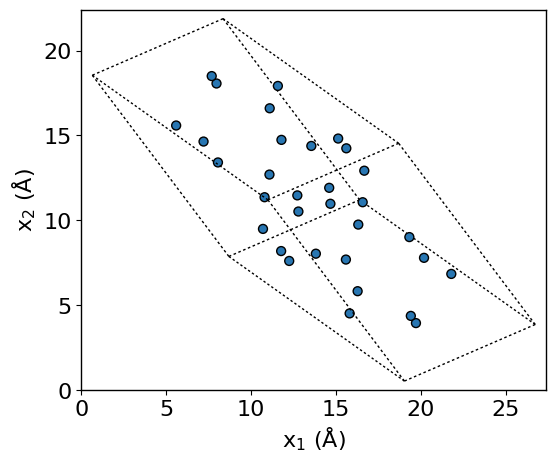

In [ ]:
# plot an example structure
i = 3 # structure index in dataframe

struct = df.iloc[i]['structure']
symbols = np.unique(list(struct.symbols))
z = dict(zip(symbols, range(len(symbols))))

fig, ax = plt.subplots(figsize=(6,5))
norm = plt.Normalize(vmin=0, vmax=len(symbols)-1)
color = [mpl.colors.to_hex(k) for k in cmap(norm([z[j] for j in list(struct.symbols)]))]
plot_atoms(struct, ax, radii=0.25, colors=color, rotation=('60x,60y,0z'))

ax.set_xlabel(r'$x_1\ (\AA)$')
ax.set_ylabel(r'$x_2\ (\AA)$')

In [ ]:
# one-hot encoding atom type and mass
type_encoding = {}
specie_am = []
for Z in tqdm(range(1, 119), bar_format=bar_format):
    specie = Atom(Z)
    type_encoding[specie.symbol] = Z - 1
    specie_am.append(specie.mass)

type_onehot = torch.eye(len(type_encoding))
am_onehot = torch.diag(torch.tensor(specie_am))

# build data
def build_data(entry, type_encoding, type_onehot, r_max=5.):
    symbols = list(entry.structure.symbols).copy()
    positions = torch.from_numpy(entry.structure.positions.copy())
    lattice = torch.from_numpy(entry.structure.cell.array.copy()).unsqueeze(0)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry.structure, cutoff=r_max, self_interaction=True)

    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    # compute edge lengths (rounded only for plotting purposes)
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)

    data = tg.data.Data(
        pos=positions, lattice=lattice, symbol=symbols,
        x=am_onehot[[type_encoding[specie] for specie in symbols]],   # atomic mass (node feature)
        z=type_onehot[[type_encoding[specie] for specie in symbols]], # atom type (node attribute)
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        edge_vec=edge_vec, edge_len=edge_len,
        phdos=torch.from_numpy(entry.phdos).unsqueeze(0)
    )

    return data

r_max = 4. # cutoff radius
df['data'] = df.progress_apply(lambda x: build_data(x, type_encoding, type_onehot, r_max), axis=1)

100%|██████████| 10/10 [00:00<00:00, 62.61it/s]


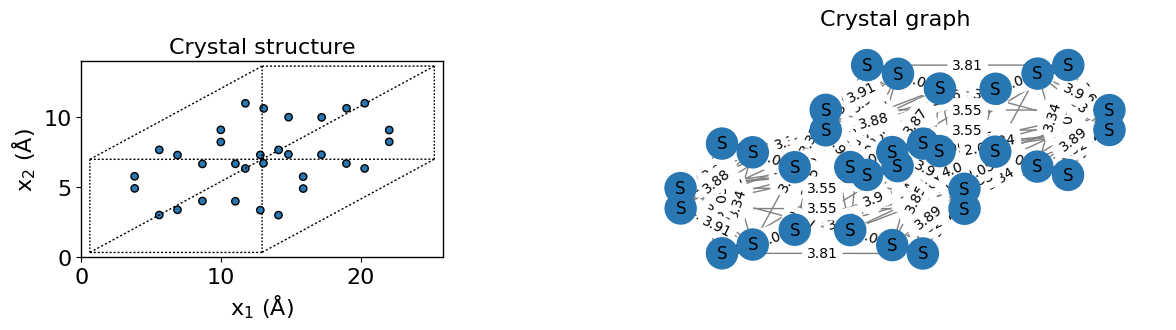

In [ ]:
i = 3
plot_example(df, i=i, label_edges=True)

In [ ]:
class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim, **kwargs):
        self.pool = False
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True

        super().__init__(**kwargs)

        self.em = nn.Linear(in_dim, em_dim)

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.x = F.relu(self.em(data.x))
        data.z = F.relu(self.em(data.z))
        output = super().forward(data)
        output = torch.relu(output)

        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)

        maxima, _ = torch.max(output, dim=1)
        output = output.div(maxima.unsqueeze(1))

        return output


out_dim = len(df.iloc[0]['phfreq'])
em_dim = 64

model = PeriodicNetwork(
    in_dim=118,
    em_dim=em_dim,
    irreps_in=str(em_dim)+"x0e",
    irreps_out=str(out_dim)+"x0e",
    irreps_node_attr=str(em_dim)+"x0e",
    layers=2,
    mul=32,
    lmax=1,
    max_radius=r_max,
    num_neighbors=15.837087001257574,
    reduce_output=True
)

print(model)

PeriodicNetwork(
  (layers): ModuleList(
    (0): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(64x0e x 64x0e -> 64x0e+32x1o | 262144 paths | 262144 weights)
        (lin1): FullyConnectedTensorProduct(64x0e x 64x0e -> 64x0e | 262144 paths | 262144 weights)
        (fc): FullyConnectedNet[10, 100, 128]
        (tp): TensorProduct(64x0e x 1x0e+1x1o -> 64x0e+64x1o | 128 paths | 128 weights)
        (lin2): FullyConnectedTensorProduct(64x0e+64x1o x 64x0e -> 64x0e+32x1o | 393216 paths | 393216 weights)
      )
      (second): Gate (64x0e+32x1o -> 32x0e+32x1o)
    )
    (1): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(32x0e+32x1o x 64x0e -> 96x0e+32x1o+32x1e | 262144 paths | 262144 weights)
        (lin1): FullyConnectedTensorProduct(32x0e+32x1o x 64x0e -> 32x0e+32x1o | 131072 paths | 131072 weights)
        (fc): FullyConnectedNet[10, 100, 160]
        (tp): TensorProduct(32x0e+32x1o x 1x0e+1x1o -> 64x0e+64x1o+

In [ ]:
# Load pre-trained model weights

device = "cuda:0" if torch.cuda.is_available() else "cpu"
run_name = 'model'

model.load_state_dict(torch.load(run_name + '.torch', map_location=device)['state'])
model.pool = True

dataloader = tg.loader.DataLoader(df['data'].values, batch_size=64)

df['phdos_pred'] = np.empty((len(df), 0)).tolist()
df['mse'] = 0.
model.to(device)
model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        loss = F.mse_loss(output, d.phdos, reduction='none').mean(dim=-1).cpu().numpy()
        df.loc[i0:i0 + len(output) - 1, 'phdos_pred'] = [[k] for k in output.cpu().numpy()]
        df.loc[i0:i0 + len(d.phdos) - 1, 'mse'] = loss
        i0 += len(output)


# pdos evaluation
model.eval()
model.to(device)
model.pool = False

df['pdos_pred'] = np.empty((len(df), 0)).tolist()

with torch.no_grad():
    for i in tqdm(range(len(df)), total=len(df), bar_format=bar_format):
        data = df['data'].iloc[i]
        data.to(device)
        output = model(data)
        df.at[i, 'pdos_pred'] = output.cpu().numpy()
df['phdos_pred'] = df['phdos_pred'].map(lambda x: x[0])

100%|██████████| 10/10 [00:00<00:00, 17.06it/s]


In [ ]:
# run only when large amount of data in df
# idx = list(range(len(df)))
# print(idx)
# plot_predictions(df,idx,'Testing')

In [ ]:
# saved in test_pred.csv with final predictions
structure_csv
structure_csv['Frequency (THz)'] = pd.Series([None]*len(structure_csv), dtype='object')
structure_csv['phDOS_pred'] = pd.Series([None]*len(structure_csv), dtype='object')
structure_csv['pDOS_pred'] = pd.Series([None]*len(structure_csv), dtype='object')

for idx, row in df.iterrows():
    pdos = row['pdos_pred']
    phdos_pred = row['phdos_pred']
    species = row['species']

    structure_csv.at[idx, 'Frequency (THz)'] = phfreq
    structure_csv.at[idx, 'phDOS_pred'] = phdos_pred.tolist()

    pdos_dict = {}
    for i, elem in enumerate(df.iloc[idx].structure.symbols):
        pdos_dict[elem]=pdos[i]
    structure_csv.at[idx, 'pDOS_pred'] = pdos_dict


In [ ]:
structure_csv['normalised_phDOS_pred'] = pd.Series([None]*len(structure_csv), dtype='object')
structure_csv['normalised_pDOS_pred'] = pd.Series([None]*len(structure_csv), dtype='object')
for i in range(len(structure_csv)):
    x = structure_csv.iloc[i]['Frequency (THz)']
    y = structure_csv.iloc[i]['phDOS_pred']
    current_area = np.trapezoid(y, x)
    structure_csv.at[i, 'normalised_phDOS_pred'] = (y / current_area * 3).tolist()
    sym = structure_csv.iloc[i]['Symbol']

    structure_csv.at[i, 'normalised_pDOS_pred'] = (structure_csv.iloc[i]['pDOS_pred'][sym]/current_area *3).tolist()

In [ ]:
structure_csv.to_csv('structure_pred.csv', index=False)

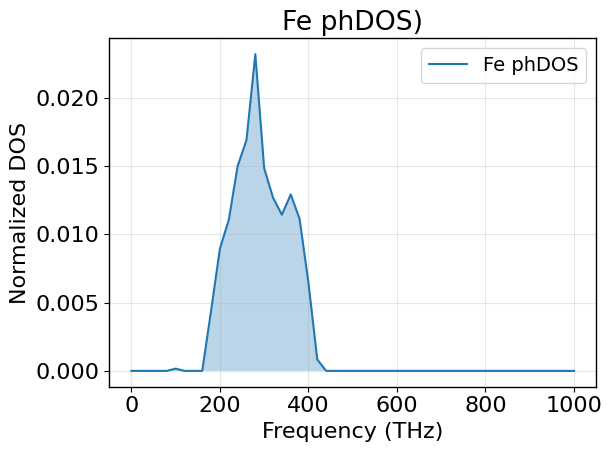

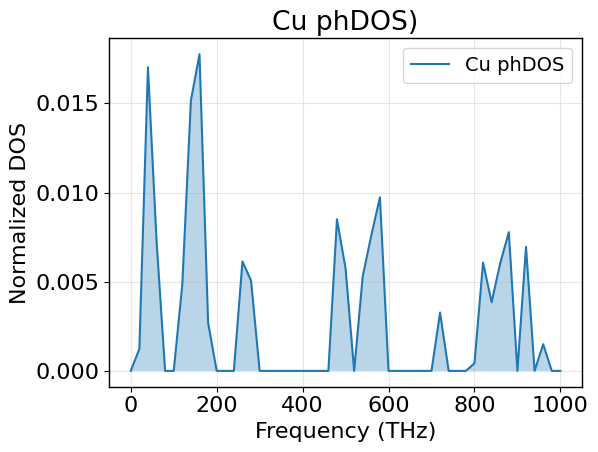

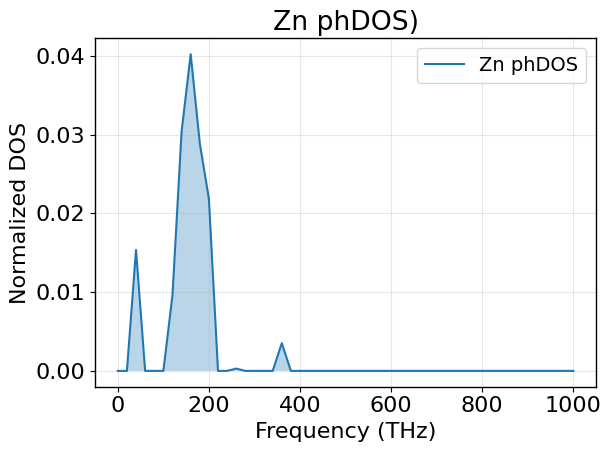

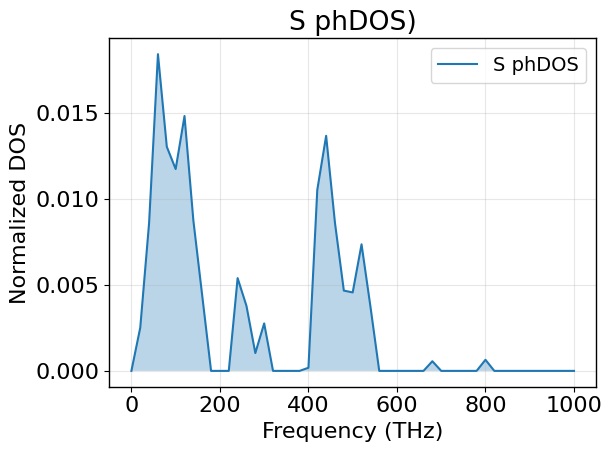

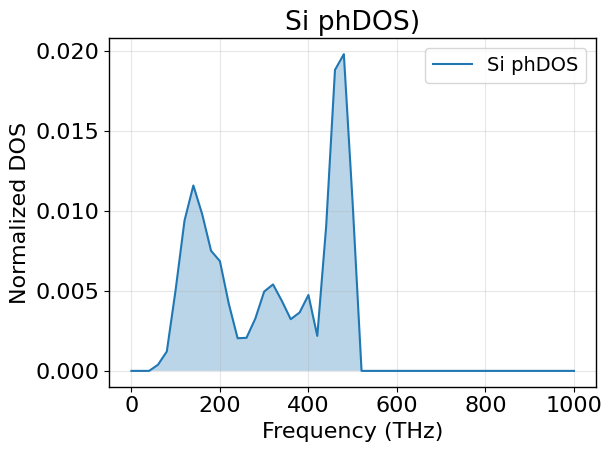

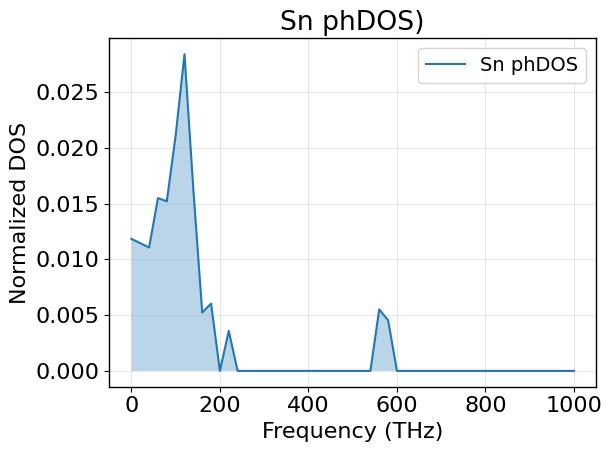

In [ ]:
sample = 5
for idx,row in structure_csv.iterrows():
  if idx > sample:
    break
  plot_freq = np.array(row['Frequency (THz)'])
  plot_phdos = np.array(row['normalised_phDOS_pred'])
  label = f"{row['Symbol']} phDOS"
  data = plot_phdos
  plt.plot(plot_freq, data, label=f'{label}')
  plt.fill_between(plot_freq, data, alpha=0.3)
  plt.xlabel('Frequency (THz)')
  plt.ylabel('Normalized DOS')
  plt.title(f'{label})')
  plt.grid(True, alpha=0.3)
  plt.legend()
  plt.tight_layout()
  plt.show()
